# **Model Testing and Evaluation**
The trained sentiment analysis model will be evaluates using both single and batch predictions. The evaluation includes a detailed analysis of the model's accuracy across different sentiment and highlights the overall performance.

In [1]:
# Suppresses INFO, WARNING, and ERROR logs.
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging
logging.getLogger().setLevel(logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

# Import Libraries.
import requests
from pprint import PrettyPrinter
import pandas as pd
import numpy as np
import base64
import json
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


## **1. Deploying the Model**
The trained model is deployed locally using TensorFlow Serving with Docker.

### **1.1. Build the Docker Image**
Build the Docker image to serve the trained model:
```bash
docker build -t sentiment-analysis-tf-serving .
```

### **1.2. Run the Docker Container**
Start the container to serve the model:
```bash
docker run -p 8080:8501 sentiment-analysis-tf-serving
```

### **1.3. Verify the Model Status**
Check if the model is available for predictions by querying the REST API.


In [2]:
# Check model status.
pp = PrettyPrinter()
pp.pprint(requests.get('http://localhost:8080/v1/models/sentiment-analysis-model').json())

{'model_version_status': [{'state': 'AVAILABLE',
                           'status': {'error_code': 'OK', 'error_message': ''},
                           'version': '1737294326'}]}


## **2. Loading Test Data**
The test dataset is loaded into a Pandas DataFrame for predictions.

- **File**: `data/test/test_preprocess.csv`
- **Columns**:
  - `text`: Input sentences for sentiment analysis.
  - `sentiment`: Ground truth labels (`0` for negative, `1` for neutral, `2` for positive).

In [3]:
# Load test data.
test_df = pd.read_csv('data/test/test_preprocess.csv')
with pd.option_context('display.max_colwidth', None):
  display(test_df.sample(10, random_state=42))

,text,sentiment
361,kesian sheila on 7 tenggelem sekarang .,0
73,"sebagai resmi broadcast , saya merasa kecewa dengan karena selain siaran yang di acak , iklan pop naik yang menutupi layar , juga tidak menayangkan pertandingan lainn nya . bahkan , menjelang asian games masih banyak sinetron reguler daripada tayangan asian games .",0
374,"dulu pernah mencoba belajar renang , tapi tenggelam , terus sekarang tidak mau lagi deh gue renang , trauma , seram .",0
155,"xiaomi . karena gue pakai xiaomi sekarang , sebelumnya oppo f1 . lebih suka xiaomi saja , baterai nya kuat . gue puas banget sih dengan xiaomi .",2
104,samsung galaxy s saya sudah diluncurkan semalam . saya kecewa desain nya standar banget . ekspektasi saya cuma terwujud 70 % . percuma terbawa sampai mimpi .,0
394,"menurut gue , bali itu pulau tercantik yang ada di indonesia .",2
377,"kalau suruh milih , gue lebih suka belanja di shopee , pelayanan nya nomor 1 .",2
124,"sebagai nasabah bank bca yang sudah lebih dari 10th , saya merasa kecewa . bca tidak dapat memberikan keamanan kepada nasabah nya . bagaimana bisa uang di rekening saya habis . terjadi transaksi berkali-kali di tanggal 19 20 mei kemarin yang bukan dilakukan oleh saya .",0
68,"kecewa berat kepada pihak stasiun tv yang mengacak siaran nya karena rakyat jelata seperti kami tidak bisa melihat timnas u23 bermain . percuma kita tuan rumah kalau rakyat indonesia sendiri tidak bisa melihat di tv , salam buat pihak yang terkait semoga kalian semua puas .",0
450,"kalau mau indonesia maju , pemimpin itu harus peka sama kebutuhan negara .",1


## **3. Single Predictions**
Single predictions are performed on selected samples from each sentiment class.

### **Procedure**
1. Select **2 samples** from each sentiment class (`negative`, `neutral`, `positive`) in `test_df`.
2. Format the samples as JSON payloads and send them to the REST API endpoint:
   ```
   http://localhost:8080/v1/models/sentiment-analysis-model:predict
   ```
3. Parse the API response to retrieve the predicted class and probabilities.

In [4]:
# Select 2 samples from each class.
sample_texts = []
for sentiment in [0, 1, 2]:
    class_samples = test_df[test_df['sentiment'] == sentiment]['text'].sample(n=2, random_state=42)
    sample_texts.extend(class_samples)

# Create examples for prediction.
sample_examples = []
for text in sample_texts:
    feature = {
        'text': tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[text.encode('utf-8')])
        )
    }
    example = tf.train.Example(
        features=tf.train.Features(feature=feature)
    )
    serialized = example.SerializeToString()
    sample_examples.append(base64.b64encode(serialized).decode('utf-8'))

# Define a mapping for sentiment labels.
sentiment_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Make predictions for samples.
instances = [{"b64": example} for example in sample_examples]
response = requests.post(
    'http://localhost:8080/v1/models/sentiment-analysis-model:predict',
    data=json.dumps({"instances": instances})
)

# Process and display results.
predictions = np.argmax(response.json()['predictions'], axis=1)
for text, pred in zip(sample_texts, predictions):
    actual_sentiment = test_df[test_df['text'] == text]['sentiment'].values[0]
    print(f"Text        : {text}\n"
          f"Predicted   : {sentiment_mapping[pred]}\n"
          f"Actual      : {sentiment_mapping[actual_sentiment]}\n")


Text        : melihat komen nya 90 % negatif jadi pikir-pikir buat mencari tiket kereta di sini . mending aplikasi yang lain saja yang sudah terbukti bagus bertahun-bertahun .
Predicted   : negative
Actual      : negative

Text        : saya hari ini melakukan pemesanan dan tiket saya tidak kunjung saya terima . padahal saya sudah menelpon pelayanan pelanggan , sudah mengirimkan email dengan bukti transfer tapi respon nya sangat lambat dan tidak jelas .
Predicted   : neutral
Actual      : negative

Text        : tidur yang cukup tiap hari nya bisa bikin badan segar .
Predicted   : positive
Actual      : neutral

Text        : saya suwandi sudah pesan tiket pak - cengkareng tuk penerbangan tanggal 20 jam 06.46 via pesawat nam air . namun sampai dengan hari ini tanggal 17 juli , saya belum terima info apa pun , transfer dari bri syariah ke bank mandiri . mohon bantuan nya untuk diinformasi kembali . terima kasih .
Predicted   : neutral
Actual      : neutral

Text        : karya anak bang

## **4. Batch Predictions**
Batch predictions evaluate the model on multiple samples simultaneously.

### **Procedure**
1. Select a subset of `test_df` for batch predictions.
2. Prepare a JSON payload containing all instances under the `instances` field.
3. Send the payload to the API endpoint for batch processing.

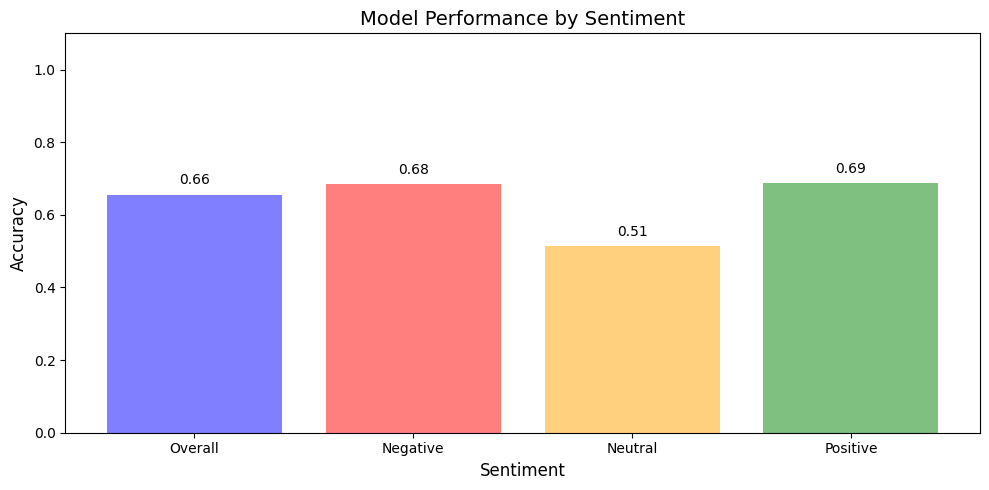

In [5]:
# Prepare the test data for prediction.
test_examples = []
for text in test_df['text'].values:
    feature = {
        'text': tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[text.encode('utf-8')])
        )
    }
    example = tf.train.Example(
        features=tf.train.Features(feature=feature)
    )
    serialized = example.SerializeToString()
    test_examples.append(base64.b64encode(serialized).decode('utf-8'))

# Batch size for processing.
BATCH_SIZE = 128

# Process batches and store predictions.
all_predictions = []
for i in range(0, len(test_examples), BATCH_SIZE):
    batch = test_examples[i:i + BATCH_SIZE]
    instances = [{"b64": example} for example in batch]
    data = json.dumps({"instances": instances})
    response = requests.post(
        'http://localhost:8080/v1/models/sentiment-analysis-model:predict',
        data=data
    )
    if response.status_code != 200:
        print(f"Request failed with status code {response.status_code}: {response.text}")
        continue
    try:
        predictions = response.json()['predictions']
        all_predictions.extend(np.argmax(predictions, axis=1))
    except KeyError as e:
        print(f"KeyError: {e}, Response: {response.json()}")
        continue

# Convert predictions to numpy array.
predictions = np.array(all_predictions)

# Classification Report.
report = classification_report(test_df['sentiment'], predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Extract relevant metrics for visualization.
metrics = {
    'Overall': report_df.loc['accuracy']['precision'],
    'Negative': report_df.loc['0']['f1-score'],
    'Neutral': report_df.loc['1']['f1-score'],
    'Positive': report_df.loc['2']['f1-score']
}

# Create bar plot.
colors = ['blue', 'red', 'orange', 'green']
plt.figure(figsize=(10, 5))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors, alpha=0.5)

plt.title('Model Performance by Sentiment', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.1)

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,  
        f'{bar.get_height():.2f}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.tight_layout()
plt.show()


## **5. Summary**
- **Strengths**:
  - High accuracy for negative and positive sentiment classes demonstrates strong generalization in identifying polar sentiments.
- **Weaknesses**:
  - The accuracy for the neutral class (`51%`) indicates potential confusion between neutral and other sentiment categories.
- **Recommendations**:
  - Explore further tuning or retraining with a more balanced dataset.
  - Consider refining the preprocessing steps to better capture linguistic nuances of neutral sentiments.